# Comparando pipelines

Para modelo semillero

Incluye:

- Comparación de modelo sem según meses de entrenamiento

In [1]:
!pip install dask[dataframe]


[notice] A new release of pip is available: 24.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Librerias
import os
import pandas as pd
import numpy as np

#######
# rutas
# datasets
from config import dataset_file_fe6_6pqt
from config import dataset_file_fe6_6xpqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
# warnings.filterwarnings('ignore', category=Warning, module='xgboost')
# warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


/home/santtedo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variables de train y test

In [3]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_3_meses = [202104, 202105, 202106]

mes_train_ult_4_meses = [202103, 202104, 202105, 202106]

mes_train_ult_6_meses = [202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_9_meses = [202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_anio = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train = [202106]
mes_test = 202108

threshold = 0.025
# comp02_back-testing
threshold_bt_mean = 0.015627
threshold_bt_median = 0.014848

semillas = [437809, 327347, 392879, 455783, 217163]

## Comparando modelos

Según cantidad de meses de entrenamiento

Se ejecutó un back-testing para comparación, testeando sobre 202106

Modelo semillerio de Denicolay

### Back-testing con 8 meses

#### Datos con fe conceptual

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6pqt)

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

mes_train_bt_8_meses = [202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104]

In [ ]:
# Simulación para Kaggle
X_train = data[data['foto_mes'].isin(mes_train_bt_8_meses)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202106 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [24]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Modelo elegido

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base XGBoost

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 91966000.0

# Optimizando el modelo


[I 2024-11-21 14:59:14,742] Using an existing study with name 'exp_xgb_pr6_fe6_tr3_x' instead of creating a new one.


Mejores parámetros para xgboost: {'n_estimators': 464, 'max_leaves': 228, 'eta': 0.026841741174110256, 'gamma': 0.6065611085207565, 'min_child_weight': 10, 'subsample': 0.8649413237261332, 'colsample_bytree': 0.5013152719066779}

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 97860000.0

# Simulando el split Kaggle y comparando modelos


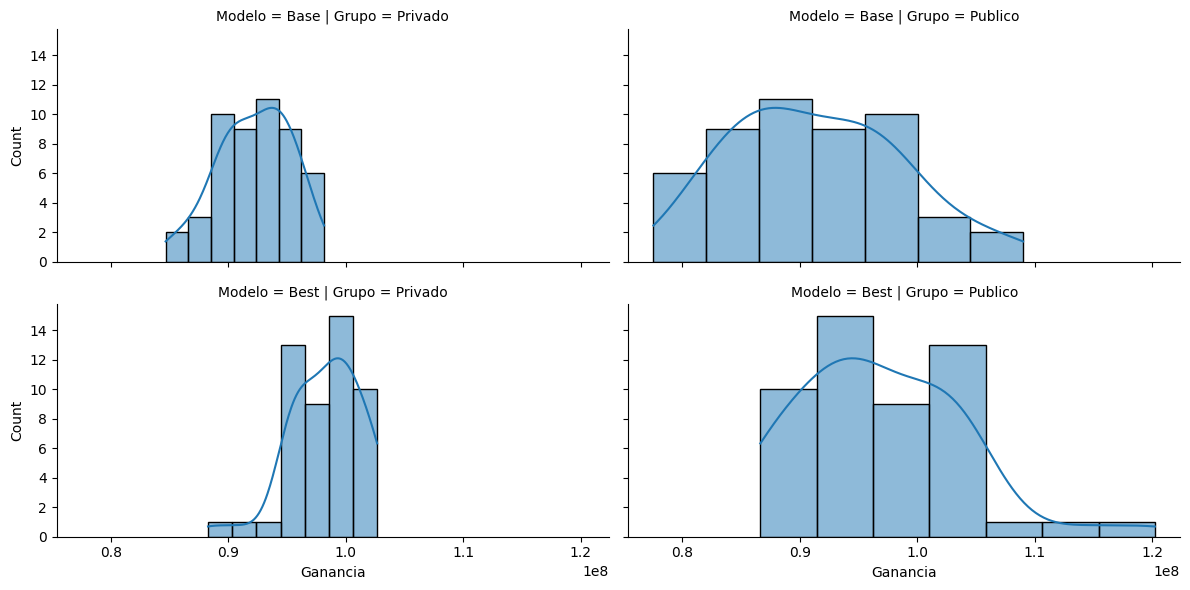

Ganancia media del modelo base en privado: 92201400.0
Ganancia media del modelo base en público: 91416733.33333336
Ganancia media del modelo Best en privado: 98265800.0
Ganancia media del modelo Best en público: 96913133.33333334


In [ ]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
# training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 2*0.2, # x2 para tratar de compenzar la falta de variables
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_sem_8m, fpri_base_lgbm_pr6_fe6_sem_8m, \
fpub_best_lgbm_pr6_fe6_sem_8m, fpub_base_lgbm_pr6_fe6_sem_8m = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) 

del X_train_imp
del X_test_imp

### Back-testing con 8 meses

#### Datos con prepro y fe x

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6xpqt)

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

mes_train_bt_8_meses = [202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104]

In [ ]:
# Simulación para Kaggle
X_train = data[data['foto_mes'].isin(mes_train_bt_8_meses)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202106 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [27]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Modelo elegido

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base XGBoost

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 90741000.0

# Optimizando el modelo


[I 2024-11-21 15:07:30,094] Using an existing study with name 'exp_xgb_pr6_fe6_tr3_x' instead of creating a new one.


Mejores parámetros para xgboost: {'n_estimators': 464, 'max_leaves': 228, 'eta': 0.026841741174110256, 'gamma': 0.6065611085207565, 'min_child_weight': 10, 'subsample': 0.8649413237261332, 'colsample_bytree': 0.5013152719066779}

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 98574000.0

# Simulando el split Kaggle y comparando modelos


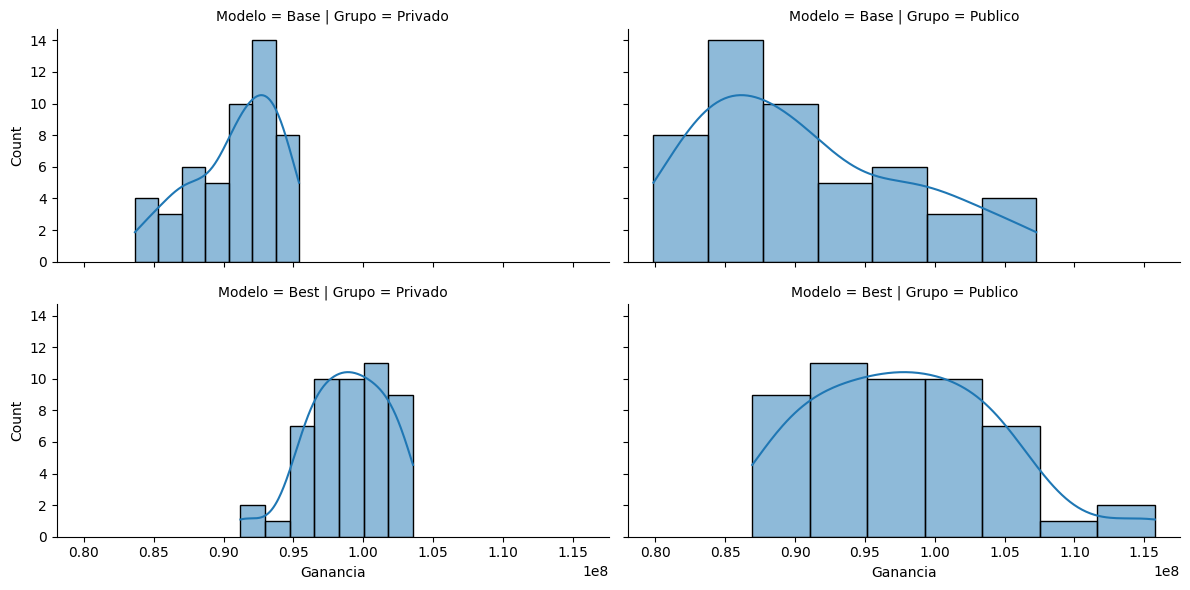

Ganancia media del modelo base en privado: 90834600.0
Ganancia media del modelo base en público: 90522600.0
Ganancia media del modelo Best en privado: 98870200.0
Ganancia media del modelo Best en público: 97882866.66666669


In [ ]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
# training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2, # idem al opt de Denicolay
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_sem_8mx, fpri_base_lgbm_pr6_fe6_sem_8mx, \
fpub_best_lgbm_pr6_fe6_sem_8mx, fpub_base_lgbm_pr6_fe6_sem_8mx = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) 

del X_train_imp
del X_test_imp

### Comparando modelos según meses de train

Comparando modelos: xgb prepro6 fe6 y 3 opt (local opt) - 8 meses vs. xgb prepro6 fe6 y 3 opt (local opt) - 10 meses


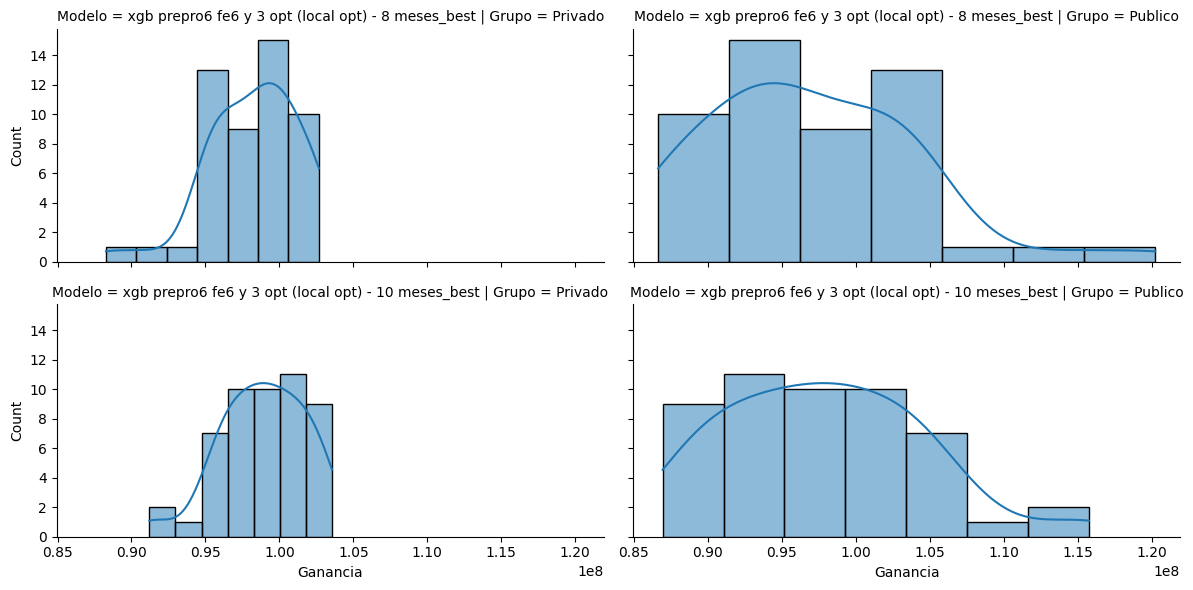

Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) - 8 meses privado: 98265800.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) - 8 meses publico: 96913133.33333334
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) - 10 meses privado: 98870200.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt) - 10 meses publico: 97882866.66666669

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1094.5
P-valor = 0.14263658420582326
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb prepro6 fe6 y 3 opt (local opt) - 10 meses_priv es mayor que la de xgb prepro6 fe6 y 3 opt (local opt) - 8 meses_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1128.5
P-valor = 0.20209478982493356
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgb prepro6 fe6 y 3 opt (local opt) - 10 meses_pub es mayor que la de xgb pre

In [ ]:
model_a = "lgbm prepro6 fe6 sem - 8 meses"
model_b = "lgbm prepro6x fe6x sem - 8 meses"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lgbm_pr6_fe6_sem_8m, fpub_best_lgbm_pr6_fe6_sem_8m,
                                model_b, fpri_best_lgbm_pr6_fe6_sem_8mx, fpub_best_lgbm_pr6_fe6_sem_8mx)

Conclusiones:

......

___